## Transit Travel time & distance
Using the Google maps API

In [1]:
import googlemaps
import geopandas as gpd
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Load data
mrdh = pd.read_pickle("../v_mrdh/areas_mrdh.pkl")
print("Source CRS:", mrdh.crs)
mrdh.head()

Source CRS: EPSG:28992


,geometry,65x65 Naam,GEBIEDEN,WONINGEN_A,INWONERS_A,ARBEIDSPL_,LLP12EO_AR,LLP0011_AR,PARKEER_TA,AUTOSPERHH,...,1: woningen,2: inwoners,3: inwon0034,4: bbv,5: llp12eo,6: detail,7: industrie,8: rest,9: arbeidspl_totaal,10: gebiedstype
65x65 Nummer,,,,,,,,,,,,,,,,,,,,,
1,"MULTIPOLYGON (((91572.39 435285.08, 91571.6 43...",Rotterdam Centrum,studiegebied RVMK,21529,36209,88158,37649,2213,4.14,0.495,...,21529,36209,18948,16284,37649,9151,7019,71988,88158,1
2,"POLYGON ((89429 435269.999, 89384 435277.999, ...",Delfshaven,studiegebied RVMK,39740,77508,17468,9165,6332,1.76,0.460,...,39740,77508,41160,30429,9165,3430,1068,12970,17468,1
3,"POLYGON ((89677.053 437491.512, 89672.17 43749...",Noord,studiegebied RVMK,29516,52490,12453,10649,2807,1.76,0.425,...,29516,52490,27808,23956,10649,3235,499,8719,12453,1
4,"POLYGON ((93801.859 437558.61, 93800.797 43756...",Kralingen,studiegebied RVMK,30714,53939,25025,36520,4257,1.76,0.480,...,30714,53939,28785,19379,36520,2758,4634,17633,25025,1
5,"POLYGON ((94944.584 431561.346, 94944.374 4315...",IJsselmonde (bi),studiegebied RVMK,22324,45467,16658,4404,3906,0.00,0.650,...,22324,45467,19990,16927,4404,2587,1931,12140,16658,1


In [3]:
# Load NS stations
ns_stations = pd.read_pickle("../travel_api/urban_stations.pkl")
print("Source CRS:", ns_stations.crs)
ns_stations.head()

Source CRS: EPSG:28992


,id,stationType,names,location,tracks,hasKnownFacilities,availableForAccessibleTravel,hasTravelAssistance,areTracksIndependentlyAccessible,isBorderStop,...,1: woningen,2: inwoners,3: inwon0034,4: bbv,5: llp12eo,6: detail,7: industrie,8: rest,9: arbeidspl_totaal,10: gebiedstype
31,"{'uicCode': '8400090', 'evaCode': '8400090', '...",LOCAL_TRAIN_STATION,"{'long': 'Barendrecht', 'medium': 'Barendrcht'...","{'lat': 51.8547210693359, 'lng': 4.5533332824707}","[1, 2, 3, 4]",True,True,True,False,False,...,19278,48738,19426,22221,5376,6030,5169,13908,25107,1
56,"{'uicCode': '8400135', 'evaCode': '8400135', '...",LOCAL_TRAIN_STATION,"{'long': 'Lansingerland-Zoetermeer', 'medium':...","{'lat': 52.042222, 'lng': 4.517222}","[1, 2]",True,True,True,True,False,...,55903,125080,50951,54981,8388,9663,6454,29994,46111,1
62,"{'uicCode': '8400147', 'evaCode': '8400147', '...",LOCAL_TRAIN_STATION,"{'long': 'Capelle Schollevaar', 'medium': 'Sch...","{'lat': 51.9541664123535, 'lng': 4.58416652679...","[1, 2]",True,True,True,False,False,...,31330,66977,26700,28611,3066,5308,4688,24613,34609,1
72,"{'uicCode': '8400166', 'evaCode': '8400166', '...",LOCAL_TRAIN_STATION,"{'long': 'Delft Campus', 'medium': 'Delft Camp...","{'lat': 51.9908332824707, 'lng': 4.36472225189...","[1, 2]",True,True,True,True,False,...,58802,103319,52411,38937,39021,6907,5996,37415,50318,1
76,"{'uicCode': '8400170', 'evaCode': '8400170', '...",INTERCITY_HUB_STATION,"{'long': 'Delft', 'medium': 'Delft', 'short': ...","{'lat': 52.0066680908203, 'lng': 4.35638904571...","[1, 2]",True,True,True,True,False,...,58802,103319,52411,38937,39021,6907,5996,37415,50318,1


In [4]:
# Load the polygons from pickle
with open("../data/polygons.pkl", "rb") as f:
    city_polygon, area_polygon = pickle.load(f)

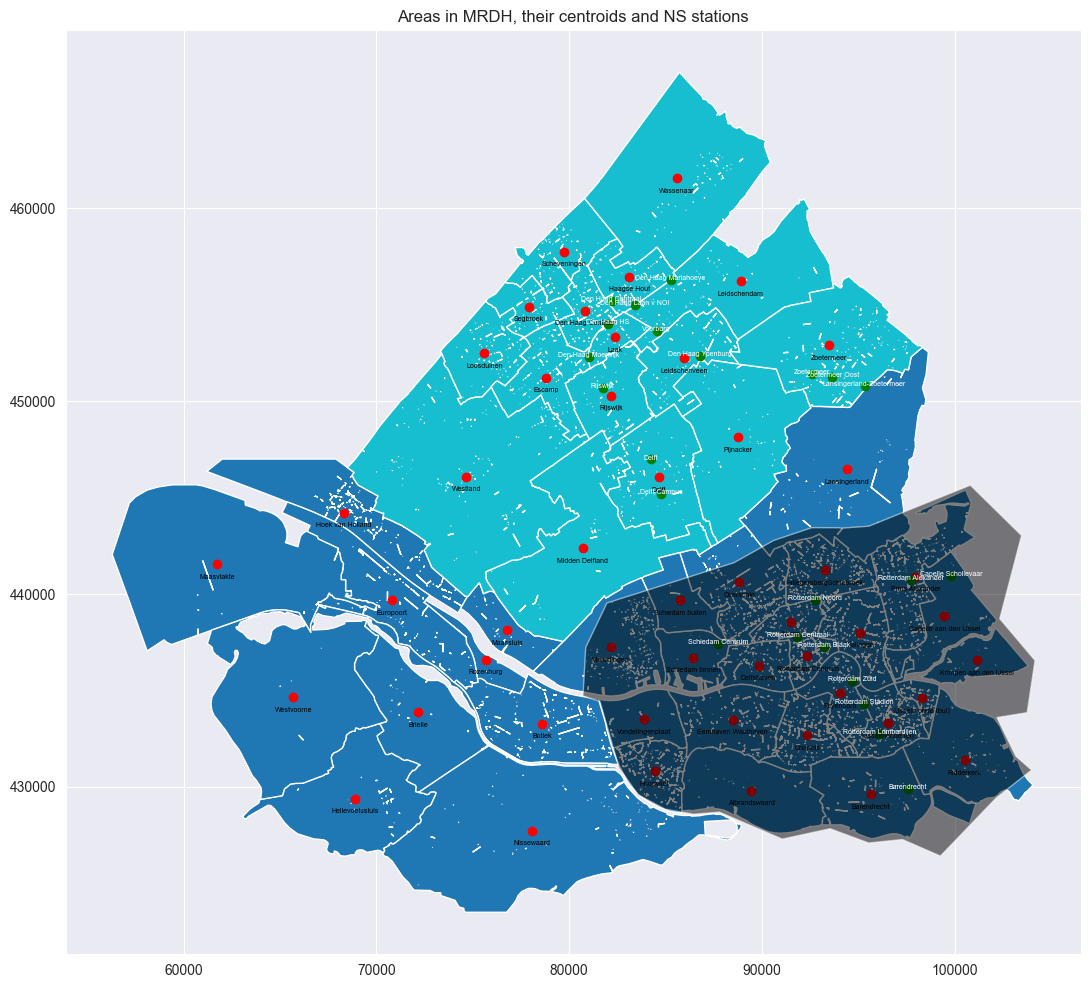

In [5]:
fig, ax = plt.subplots(figsize=(16, 12))
# Filter data to only include postcodes in the Randstad
mrdh.plot(column="GEBIEDEN", figsize=(16, 12), ax=ax)
# Add the centroids
mrdh.centroid.plot(ax=ax, color="red")
# Add the name labels above the centroids
for x, y, label in zip(mrdh.centroid.x, mrdh.centroid.y-750, mrdh["65x65 Naam"]):
    ax.text(x, y, label, color="black", fontsize=5, ha="center")
    
# Add the NS stations
ns_stations.plot(ax=ax, color="green")
# Add the name labels above the NS stations
for x, y, label in zip(ns_stations.geometry.x, ns_stations.geometry.y, ns_stations["name"]):
    ax.text(x, y, label, color="white", fontsize=5, ha="center")

# Add the city polygon (CRS 3857)
city_polygon_series = gpd.GeoSeries(city_polygon, crs="epsg:4326")
# Convert to epsg:28992
city_polygon_series = city_polygon_series.to_crs(epsg=28992)
city_polygon_series.plot(ax=ax, color="black", alpha=0.5)
# Add a title
plt.title("Areas in MRDH, their centroids and NS stations")
# Save the plot
plt.savefig("img/areas_mrdh_ns_stations.png", dpi=300, bbox_inches="tight")

### Add the 65x65 areas to the population data

In [6]:
# Load areas_65.pkl
areas_65 = pd.read_pickle("../v_mrdh/areas_65.pkl")

In [7]:
# Load the population data
population = pd.read_pickle("../data/population_data_pc4.pkl")
# Remove 0 inhabitants
population = population[population['aantal_inwoners'] > 0]

In [8]:
# Perform the spatial join with the 'touches' predicate
pop_mrdh = gpd.sjoin(population, areas_65, how='inner', predicate='intersects')

# Calculate the intersection areas
pop_mrdh['intersection_area'] = pop_mrdh.apply(
    lambda row: row.geometry.intersection(areas_65.loc[row['65x65 Nummer']].geometry).area, axis=1
)

# Sort the result by intersection area in descending order and drop duplicates, keeping the largest
pop_mrdh = pop_mrdh.sort_values(by='intersection_area', ascending=False)
# Drop duplicates, keeping one row per postcode
pop_mrdh = pop_mrdh.drop_duplicates(subset='postcode', keep='first')

In [9]:
# Stupid fix for an extra polygon in the multipolygon geometry in postcode 3053 and 2641
from shapely.geometry import MultiPolygon

pop_mrdh.loc[pop_mrdh["postcode"] == 3053, 'geometry'] = pop_mrdh.loc[pop_mrdh["postcode"] == 3053, 'geometry'].apply(lambda geom: MultiPolygon(list(geom.geoms)[:-1]) if isinstance(geom, MultiPolygon) else geom)
pop_mrdh.loc[pop_mrdh["postcode"] == 2641, 'geometry'] = pop_mrdh.loc[pop_mrdh["postcode"] == 2641, 'geometry'].apply(lambda geom: MultiPolygon(list(geom.geoms)[:-1]) if isinstance(geom, MultiPolygon) else geom)

In [10]:
# Remove areas with 0 INWONERS_A
pop_mrdh = pop_mrdh[pop_mrdh['INWONERS_A'] > 0]
mrdh = mrdh[mrdh['INWONERS_A'] > 0]

# Remove areas from mrdh with no population
# mrdh = mrdh[mrdh.index.isin(pop_mrdh['65x65 Nummer'])]

In [11]:
# Save 
pop_mrdh.to_pickle("../data/population_data_pc4_65coded.pkl")

### Calculate weighted centroids

In [12]:
# Drop any columns with a 65x65 Nummer that not in the mrdh index
pop_mrdh_sel = pop_mrdh[pop_mrdh['65x65 Nummer'].isin(mrdh.index)]

In [13]:
from shapely.geometry import Point

# Step 1: Group by 65x65 Nummer
grouped = pop_mrdh_sel.groupby('65x65 Nummer')

# Step 2: Calculate weighted centroids
def weighted_centroid(group):
    total_population = group['aantal_inwoners'].sum()
    wx = (group.geometry.centroid.x * group['aantal_inwoners']).sum() / total_population
    wy = (group.geometry.centroid.y * group['aantal_inwoners']).sum() / total_population
    return pd.Series({'geometry': Point(wx, wy), 'total_population': total_population})

# Apply the function to selected columns
weighted_centroids = grouped[['geometry', 'aantal_inwoners']].apply(weighted_centroid).reset_index()

# Step 3: Create a new geodataframe with the results. Set the 65x65 Nummer as the index
result_gdf = gpd.GeoDataFrame(weighted_centroids, geometry='geometry')
result_gdf.set_index('65x65 Nummer', inplace=True)

# Step 4: Add the weighted centroids to the mrdh geodataframe
mrdh = mrdh.copy()  # Create a copy to avoid SettingWithCopyWarning
mrdh.loc[:, 'weighted_centroid'] = result_gdf['geometry']

# Save the result
mrdh.to_pickle("../data/areas_mrdh_weighted_centroids.pkl")

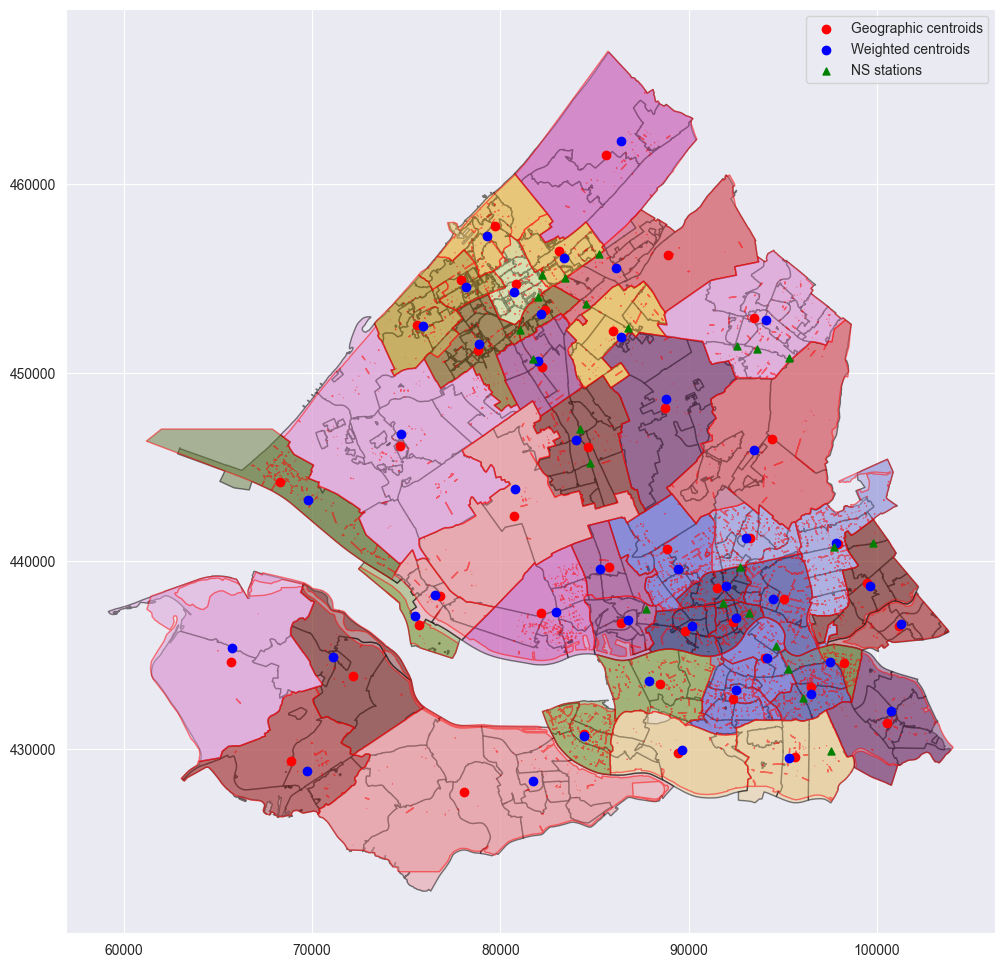

In [14]:
# Plot the population over the map
fig, ax = plt.subplots(figsize=(16, 12))
pop_mrdh_sel.plot(figsize=(16, 12), ax=ax, alpha=0.5, column="65x65 Nummer", cmap="tab20b", edgecolor="black")
mrdh.plot(column=mrdh.index.values, figsize=(16, 12), ax=ax, cmap='tab20b', alpha=0.5, edgecolor='red')
# Add the centroids
mrdh.centroid.plot(ax=ax, color="red")
# Add the weighted centroids
mrdh.weighted_centroid.plot(ax=ax, color="blue")
# Add the NS stations, as a triangle
ns_stations.plot(ax=ax, color="green", marker="^", markersize=25)
# Add a legend
ax.legend(["Geographic centroids", "Weighted centroids", "NS stations"])
# Save the plot
plt.savefig("img/population_areas_mrdh2.png", dpi=300, bbox_inches="tight")

In [15]:
# Save the population data
pop_mrdh_sel.to_pickle("../data/population_data_pc4_mrdh.pkl")

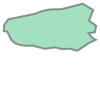

In [16]:
city_polygon

In [17]:
# Select only the 65x65 areas with centroids in the polygon (city_polygon_series
city65 = mrdh[mrdh.centroid.within(city_polygon_series.geometry[0])]
pc65 = pop_mrdh_sel[pop_mrdh_sel['65x65 Nummer'].isin(city65.index)]

# Select the NS stations within the polygon
ns_stations_city = ns_stations[ns_stations.geometry.within(city_polygon_series.geometry[0])]

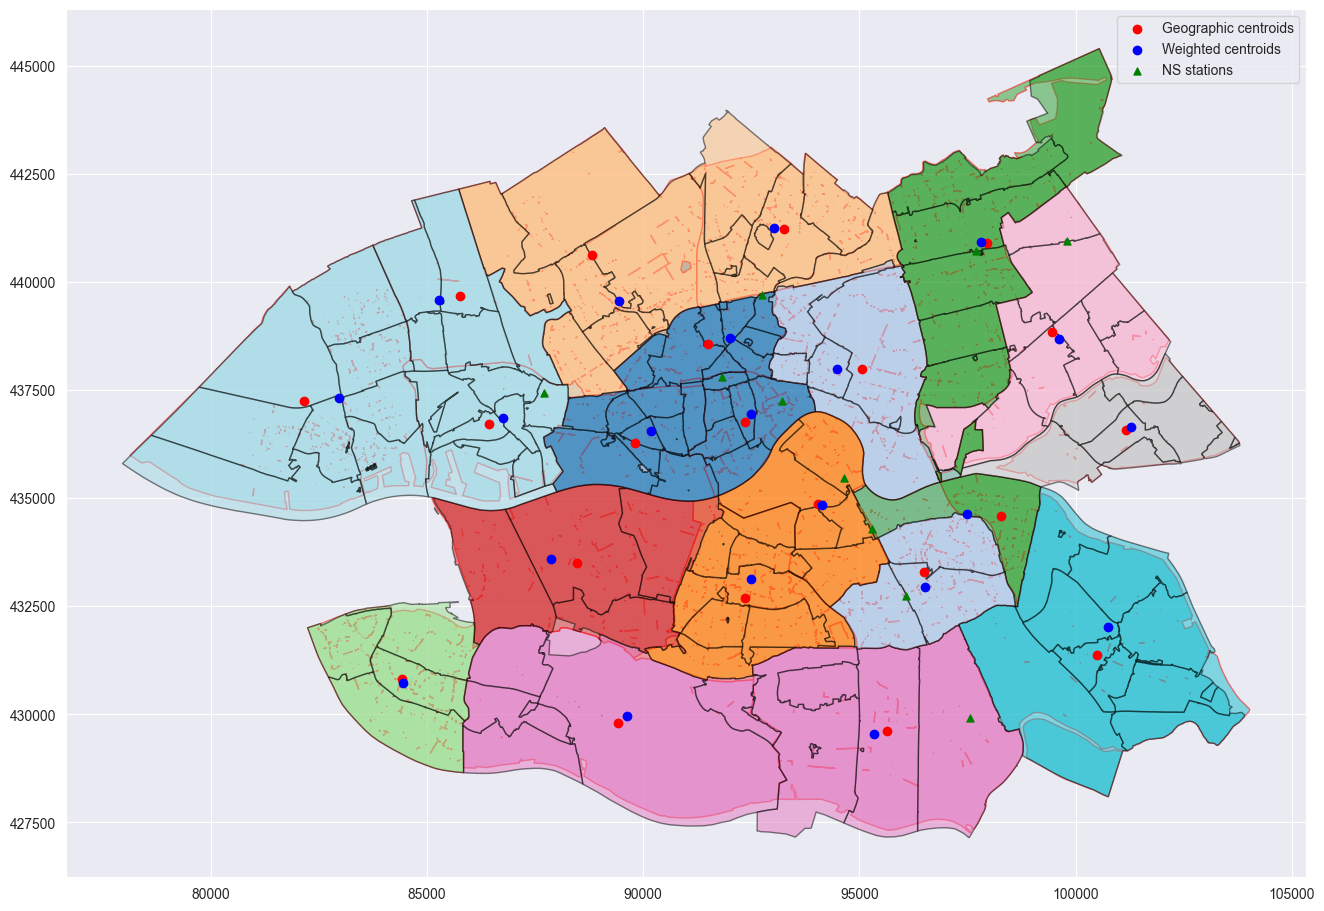

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(16, 12))
city65.plot(column=city65.index.values, ax=ax, cmap='tab20', alpha=0.5, edgecolor='red')
pc65.plot(column="65x65 Nummer", ax=ax, alpha=0.5, cmap="tab20", edgecolor="black")
# Add the centroids
city65.centroid.plot(ax=ax, color="red")
# Add the weighted centroids
city65.weighted_centroid.plot(ax=ax, color="blue")
# Add the NS stations, as a triangle
ns_stations_city.plot(ax=ax, color="green", marker="^", markersize=25)
# Add a legend
ax.legend(["Geographic centroids", "Weighted centroids", "NS stations"])

# Save the plot
plt.savefig("img/rotterdam_65_grid_centroids.png", dpi=300, bbox_inches="tight")

### Google maps API

In [19]:
# time: 2024-09-19 08:00:00 (a Thursday)
time = datetime(2024, 9, 19, 8, 0, 0)
print(time)

2024-09-19 08:00:00


In [20]:
# Select stedelijkheid 5 or higher
data_sel = city65.copy()

# Convert to EPSG:4326
data_sel = data_sel.to_crs(epsg=4326)
print("Destination CRS:", data_sel.crs)

# Convert weighted centroids to epsg:4326
data_sel["weighted_centroid"] = data_sel["weighted_centroid"].set_crs(epsg=28992).to_crs(epsg=4326)

Destination CRS: EPSG:4326


In [21]:
# Get API key from /secrets/gmaps_api_key.txt
with open("../secrets/gmap_api_key.txt") as f:
    api_key = f.readline()

In [22]:
# Single query
time_1 = datetime(2024, 7, 2, 8, 30, 0)
origin_1 = ["Rotterdam Alexander, 3068 AV Rotterdam"]
destinations_1 = ["Delft Campus, 2623 CS Delft"]
mode_1 = "transit"
run_1 = False

if run_1:
    gmaps = googlemaps.Client(key=api_key)
    result = gmaps.distance_matrix(
        origins=origin_1,
        destinations=destinations_1,
        mode=mode_1,
        departure_time=time_1,
    )
    result

In [23]:
def run_google_maps(mode, redownload=False):
    if redownload:
        gmaps = googlemaps.Client(key=api_key)
        
        # Extract centroids and convert them to a suitable format for the Google Maps API
        centroids = data_sel["weighted_centroid"]
        # Select the first two centroids for testing
        # centroids = centroids[-2:]
        locations = [(centroid.y, centroid.x) for centroid in centroids]
        print(f"{len(locations)} locations: {locations}")
    
        # Initialize dictionaries to hold the travel info
        travel_time_pc4 = {}
        travel_distance_pc4 = {}
    
        # Make 21 requests, each with 21 origins and 21 destinations
        for i in range(len(locations)):
            origin = [locations[i]]
            destinations = locations
    
            result = gmaps.distance_matrix(
                origins=origin,
                destinations=destinations,
                mode=mode,
                departure_time=time,
            )
            
            # Extract distances and populate the corresponding row in the distance matrix
            for j in range(len(destinations)):
                if i != j:
                    element = result["rows"][0]["elements"][j]
                    # origin_pc4 = data_sel["65x65 Naam"].iloc[i]
                    # destination_pc4 = data_sel["65x65 Naam"].iloc[j]
                    # key = (origin_pc4, destination_pc4)
                    # Just use the index for now
                    key = (i, j)
                    
                    if element["status"] == "OK":
                        distance_meters = element["distance"]["value"]
                        duration_seconds = element["duration"]["value"]
                        
                        # Update the travel info dictionaries
                        travel_distance_pc4[key] = distance_meters
                        travel_time_pc4[key] = duration_seconds
                    else:
                        print(f"Error for {key}: {element['status']}")
                    if i == 0 and j == 1:
                        print(f"Example for {key}: {element}")
                        print(result)

        # Correct dict keys. The keys are now (index, index) instead of (n65, n65)
        key_to_n65 = {i: n65 for i, n65 in enumerate(data_sel.index)}
        travel_time_pc4 = {(key_to_n65[key[0]], key_to_n65[key[1]]): value for key, value in travel_time_pc4.items()}
        travel_distance_pc4 = {(key_to_n65[key[0]], key_to_n65[key[1]]): value for key, value in travel_distance_pc4.items()}

        # Save as pickle
        with open(f"../data/travel_time_distance_google_{mode}.pkl", "wb") as f:
            pickle.dump((travel_time_pc4, travel_distance_pc4), f)
        print(f"Saved travel_time_distance_google_{mode}.pkl")

    else:
        print(f"Skipping Google Maps API, loading: travel_time_distance_google_{mode}.pkl")
        with open(f"../data/travel_time_distance_google_{mode}.pkl", "rb") as f:
            travel_time_pc4, travel_distance_pc4 = pickle.load(f)

    return travel_time_pc4, travel_distance_pc4

# Run the Google Maps API
travel_time_dict = {}
travel_distance_dict = {}

redownload = False
for mode in ["transit", "bicycling"]:
    travel_time, travel_distance = run_google_maps(mode=mode, redownload=redownload)
    travel_time_dict[mode] = travel_time
    travel_distance_dict[mode] = travel_distance

Skipping Google Maps API, loading: travel_time_distance_google_transit.pkl
Skipping Google Maps API, loading: travel_time_distance_google_bicycling.pkl


In [24]:
key_list = list(travel_time_dict["transit"].keys())
# The keys are tuples. Get the unique values for the first element
unique_keys = set([key[0] for key in key_list])
print(f"Unique keys: {unique_keys}")

Unique keys: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 28, 29, 31, 34, 41, 43, 44, 45}


In [25]:
# # Create a dict mapping the 65x65 area names to the indices
# name_to_index = {name: i for i, name in enumerate(data_sel["65x65 Naam"])}
# 
# # replace the (name, name) keys with the (index, index) keys
# for mode in travel_time_dict.keys():
#     travel_time_dict[mode] = {(name_to_index[key[0]], name_to_index[key[1]]): value for key, value in travel_time_dict[mode].items()}
#     travel_distance_dict[mode] = {(name_to_index[key[0]], name_to_index[key[1]]): value for key, value in travel_distance_dict[mode].items()}
# 
#     # Save as pickle
#     with open(f"../data/travel_time_distance_google_{mode}.pkl", "wb") as f:
#         pickle.dump((travel_time_dict[mode], travel_distance_dict[mode]), f)

In [26]:
# n65 number to name
n65_to_name = data_sel["65x65 Naam"].to_dict()

# replace the (index, index) keys with the (name, name) keys
for mode in travel_time_dict.keys():
    travel_time_dict[mode] = {(n65_to_name[key[0]], n65_to_name[key[1]]): value for key, value in travel_time_dict[mode].items()}
    travel_distance_dict[mode] = {(n65_to_name[key[0]], n65_to_name[key[1]]): value for key, value in travel_distance_dict[mode].items()}

In [27]:
# Create dataframe from the first mode in the dictionary
first_mode = next(iter(travel_time_dict))
travel_time_df = pd.DataFrame.from_dict(travel_time_dict[first_mode], orient='index', columns=[first_mode])

# Add columns for other modes
for mode, times in travel_time_dict.items():
    if mode != first_mode:
        travel_time_df[mode] = times.values()

# Split index into Origin and Destination
travel_time_df.index = pd.MultiIndex.from_tuples(travel_time_df.index, names=['Origin', 'Destination'])
travel_time_df["trans-bike-diff"] = travel_time_df["transit"] - travel_time_df["bicycling"]
travel_time_df.head(3)

transit  bicycling  trans-bike-diff
Origin            Destination                                     
Rotterdam Centrum Delfshaven       863        615              248
                  Noord           1218        516              702
                  Kralingen        558        628              -70

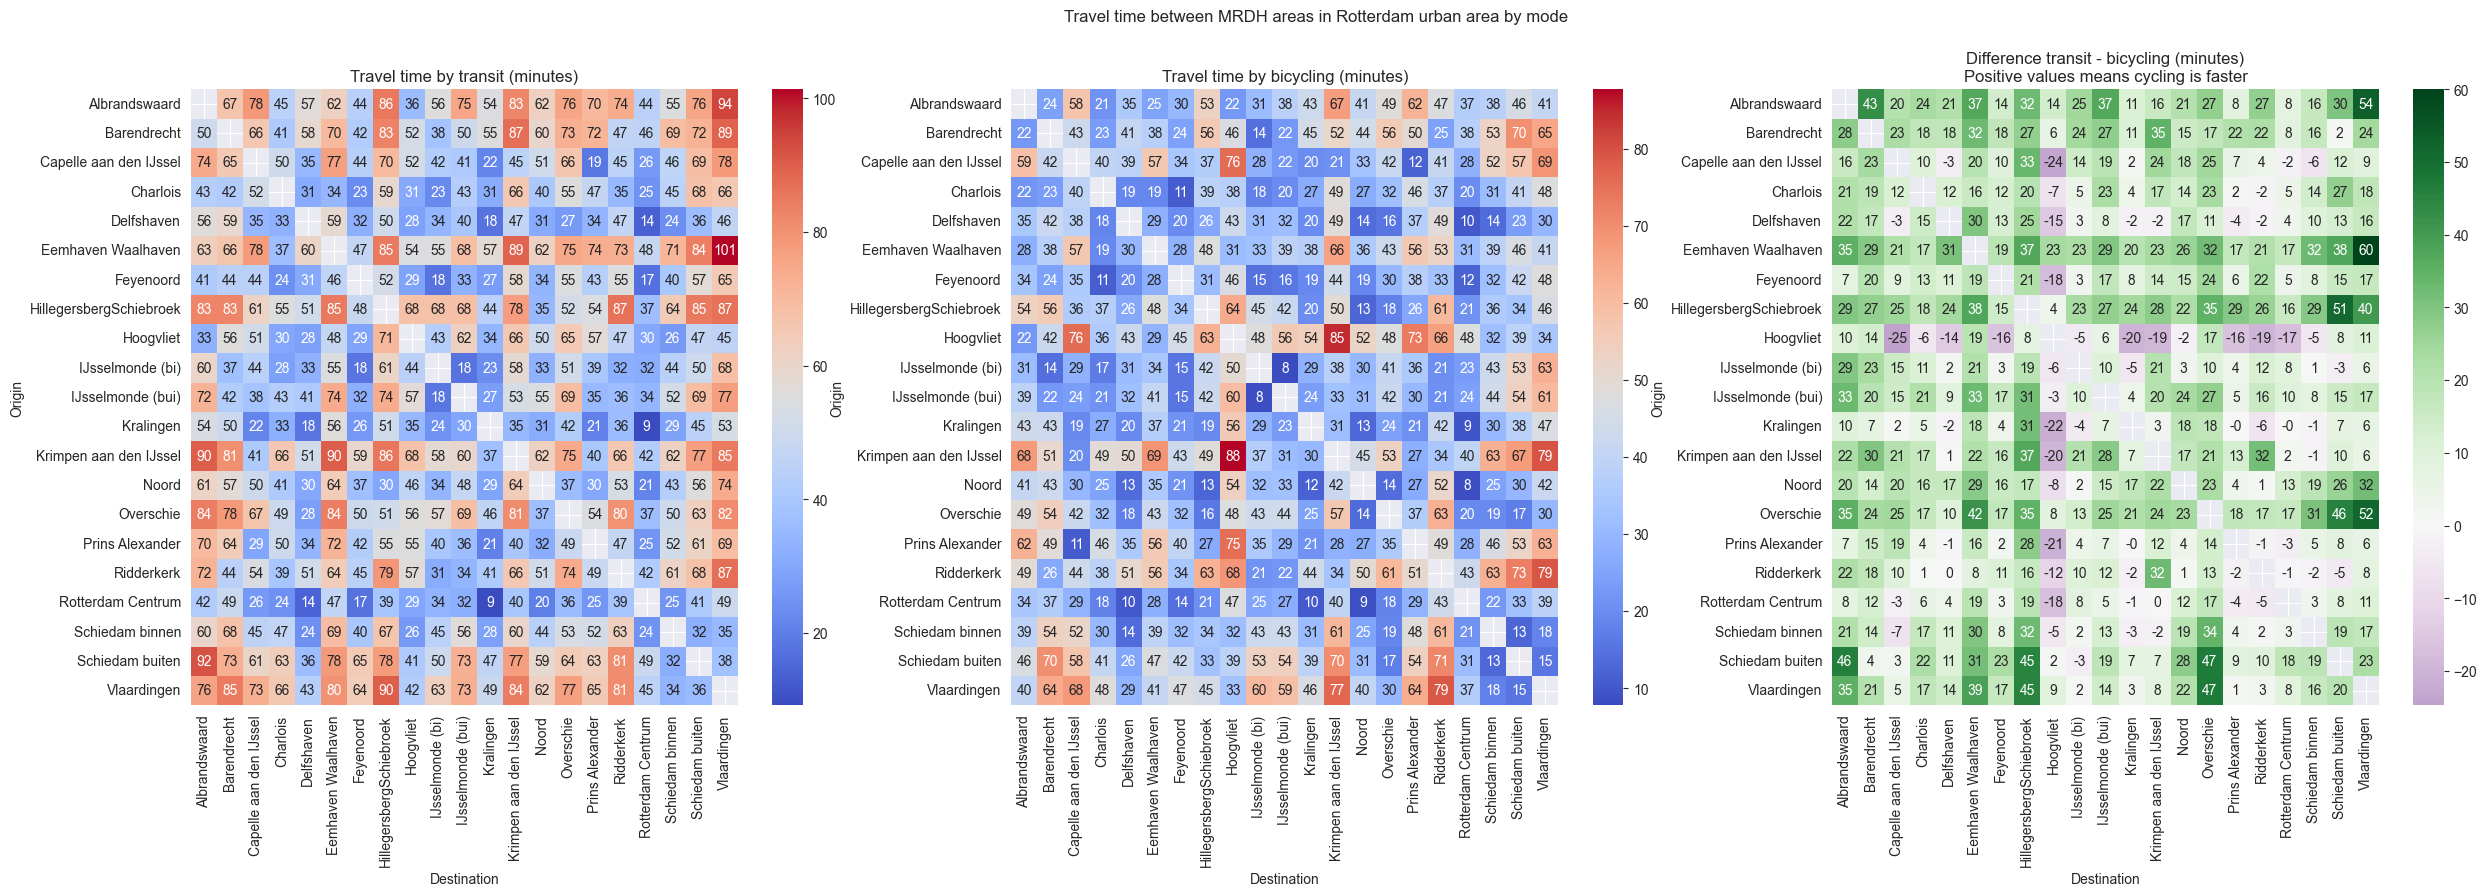

In [28]:
# Create two subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 8))

# Directly use travel_time_df
for i, mode in enumerate(travel_time_dict.keys()):
    # Heatmap with seaborn
    sns.heatmap((travel_time_df[mode]/60).unstack(), annot=True, fmt=".0f", cmap="coolwarm", ax=axs[i])
    axs[i].set_title(f"Travel time by {mode} (minutes)")

# Add a plot with the difference between the two modes. Set 0 as the middle value.
sns.heatmap((travel_time_df["trans-bike-diff"]/60).unstack(), annot=True, fmt=".0f", cmap="PRGn", ax=axs[2], center=0)
axs[2].set_title("Difference transit - bicycling (minutes)\nPositive values means cycling is faster")

# Add title
plt.suptitle("Travel time between MRDH areas in Rotterdam urban area by mode")
# Save the plot
plt.savefig("img/travel_time_heatmap.png", dpi=300, bbox_inches="tight")

In [29]:
# Convert the data to epsg:28992
data = data_sel.to_crs(epsg=28992)

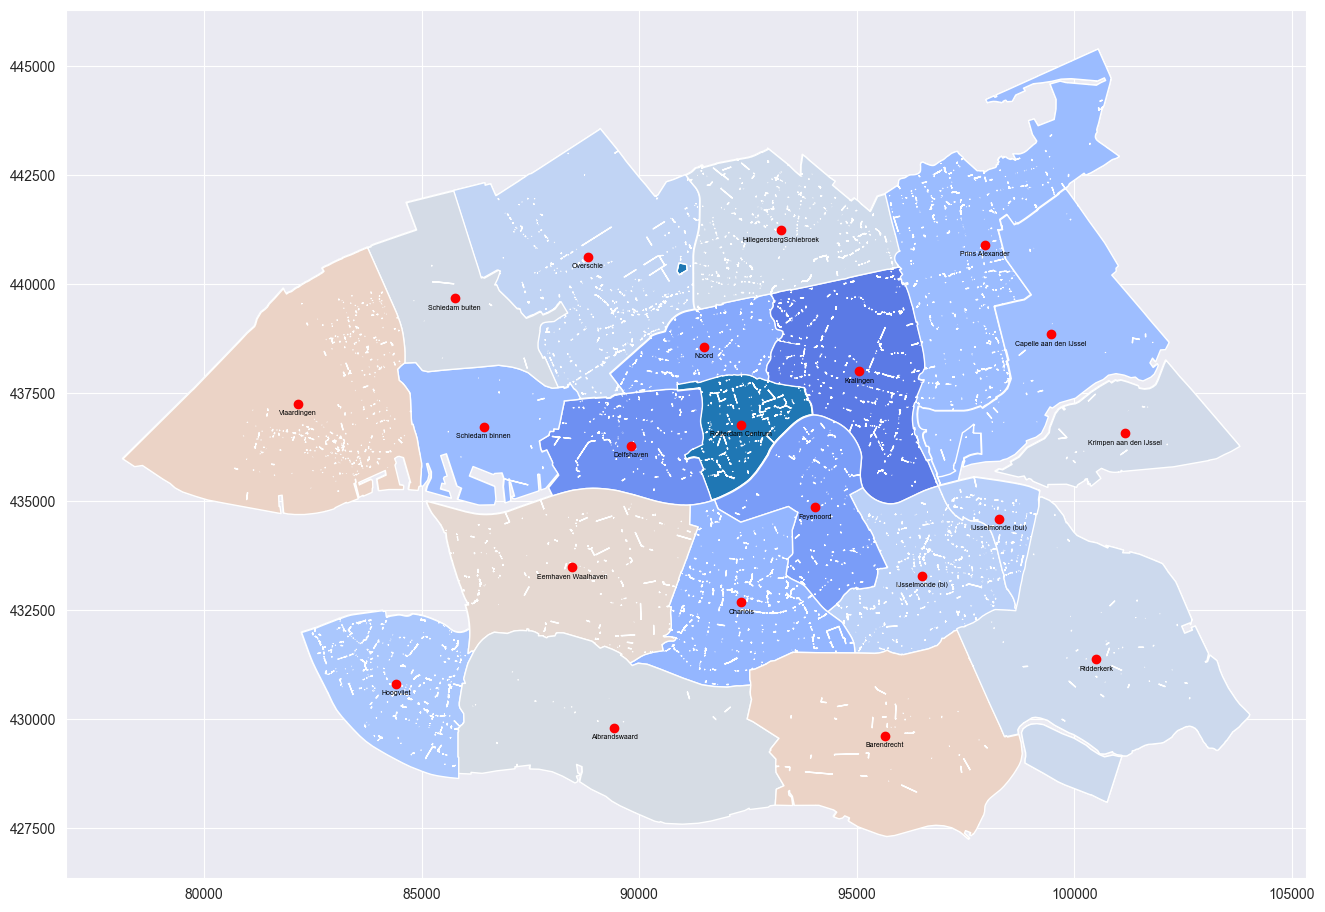

In [30]:
mode_m = "transit"
origin_m = "Rotterdam Centrum"
# Plot a map with the travel time from Rotterdam Centrum to all other areas. Green means short travel time, red means long travel time
fig, ax = plt.subplots(figsize=(16, 12))
data.plot(column="GEBIEDEN", figsize=(16, 12), ax=ax)
# Add the name labels above the centroids
for x, y, label in zip(data.centroid.x, data.centroid.y-250, data["65x65 Naam"]):
    ax.text(x, y, label, color="black", fontsize=5, ha="center")
# Add the travel time from Rotterdam Centrum
for idx, row in data.iterrows():
    destination = row["65x65 Naam"]
    if destination == origin_m:
        continue
    travel_time = travel_time_dict[mode_m][(origin_m, destination)]
    if travel_time is not None:
        color = sns.color_palette("coolwarm", as_cmap=True)(travel_time / travel_time_df[mode].max())
        data[data["65x65 Naam"] == destination].plot(color=color, ax=ax)
# Add the centroids
data.centroid.plot(ax=ax, color="red")
# Save the plot
plt.savefig(f"img/travel_time_{origin_m.lower().replace(' ', '_')}_{mode_m}.png", dpi=300, bbox_inches="tight")

In [31]:
from geopy.distance import geodesic

In [32]:
# Calculate the distance between all centroids
distances = {}
for i, origin in data_sel.iterrows():
    for j, destination in data_sel.iterrows():
        if i != j:
            key = (origin["65x65 Naam"], destination["65x65 Naam"])
            distances[key] = geodesic((origin["weighted_centroid"].y, origin["weighted_centroid"].x), (destination["weighted_centroid"].y, destination["weighted_centroid"].x)).kilometers

In [33]:
# Add the distances to the travel_time_df
travel_time_df["distance"] = [distances[key] for key in travel_time_df.index]
travel_time_df.head(3)

transit  bicycling  trans-bike-diff  distance
Origin            Destination                                               
Rotterdam Centrum Delfshaven       863        615              248  2.353400
                  Noord           1218        516              702  1.808959
                  Kralingen        558        628              -70  2.230800

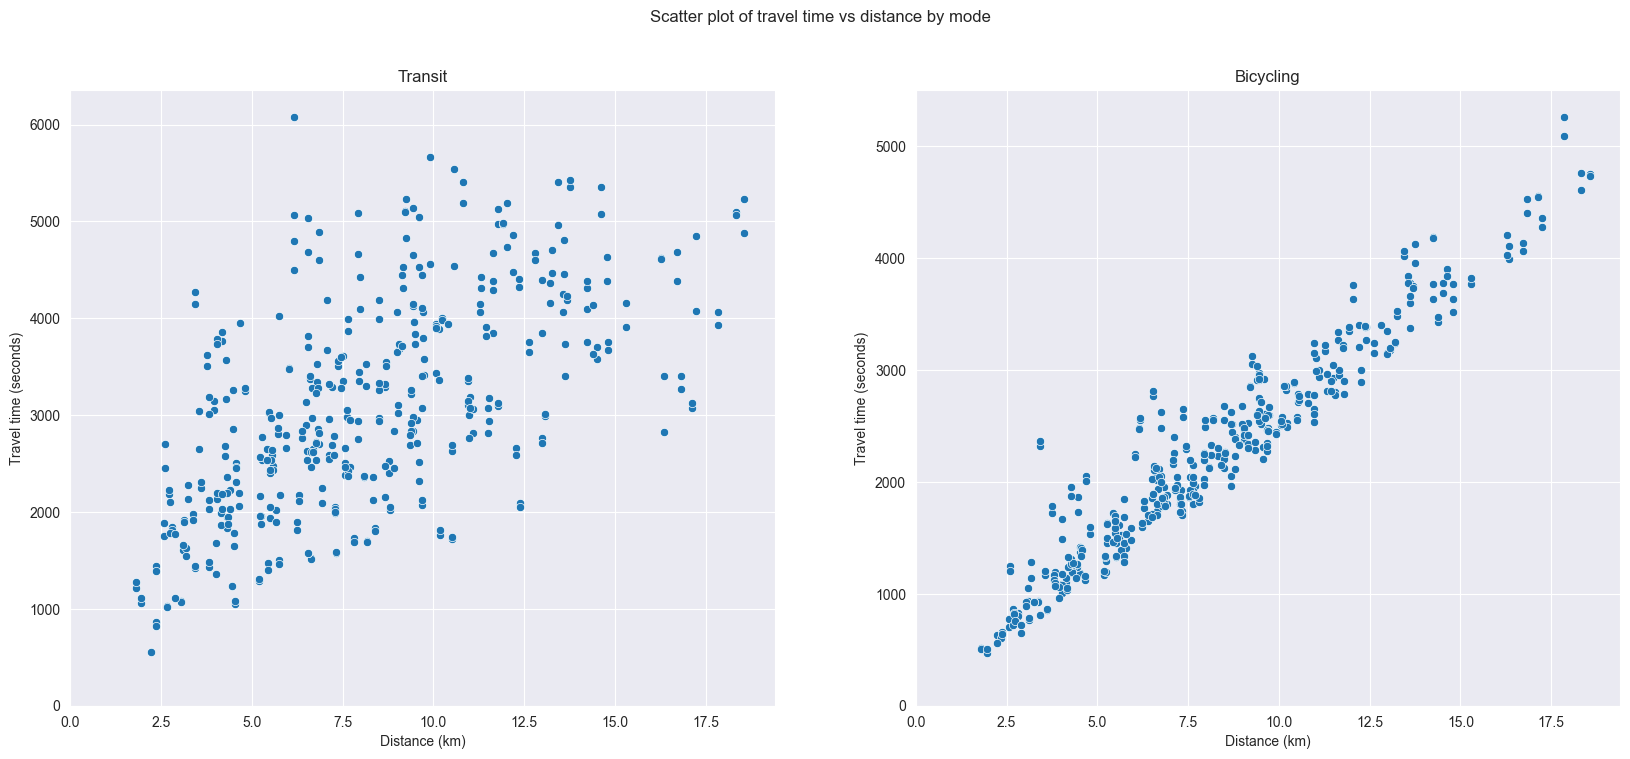

In [34]:
# Create two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

for i, mode in enumerate(travel_time_dict.keys()):
    # Scatter plot with seaborn
    sns.scatterplot(data=travel_time_df, x="distance", y=mode, ax=axs[i])
    axs[i].set_title(mode.capitalize())
    axs[i].set_xlabel("Distance (km)")
    axs[i].set_ylabel("Travel time (seconds)")
    # X and y axis start at 0
    axs[i].set_xlim(0, None)
    axs[i].set_ylim(0, None)

# Add title
plt.suptitle("Scatter plot of travel time vs distance by mode")
# Save the plot
plt.savefig("img/travel_time_distance_scatter.png", dpi=300, bbox_inches="tight")

### Areas and resolutions
This project has 4 relevant areas:
- The Netherlands
- The Metropoolregio Rotterdam Den Haag (MRDH)
- The "area" polygon, which is currently Rotterdam with some margin, custom defined.
- The "city" polygon, which is the currently city of Rotterdam, custom defined.

The resolutions are as follows:
- pc4: Postcode 4, the first 4 digits of the postcode
- v65: The 65x65 areas, as used in the V-MRDH traffic model

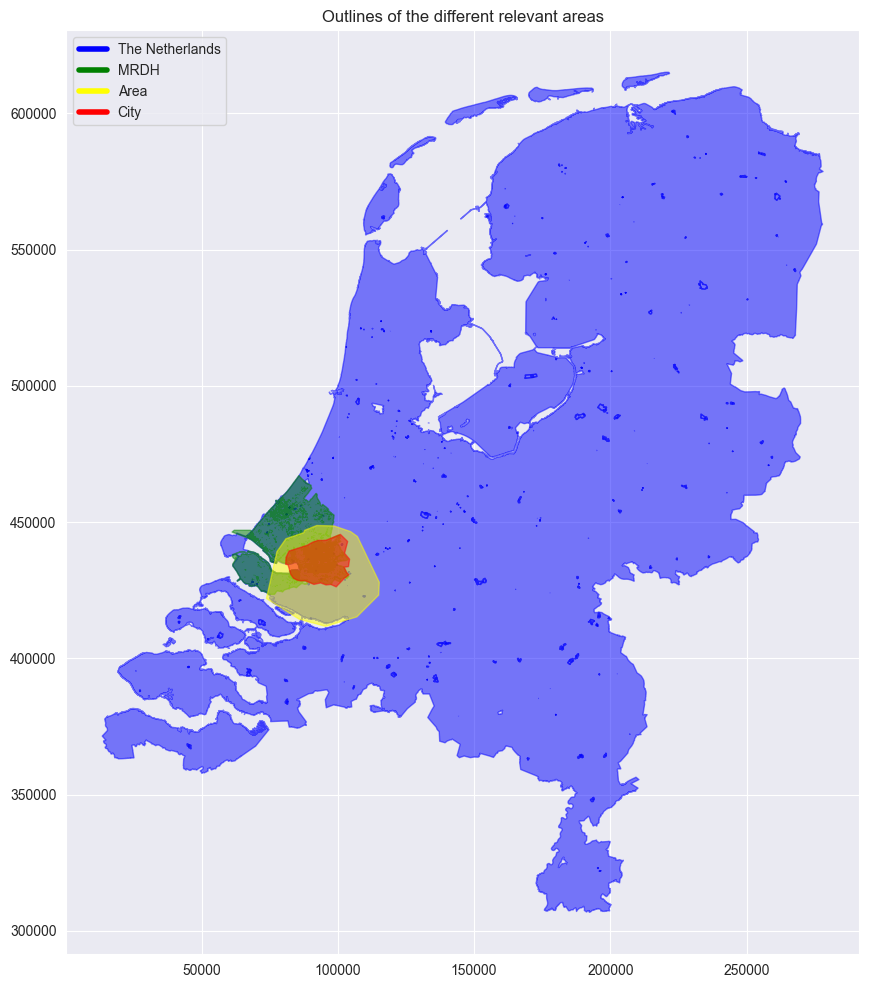

In [35]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot the outlines of the different relevant areas
fig, ax = plt.subplots(figsize=(16, 12))

# Plot the outlines of the areas
nl_outline = population.union_all()
gpd.GeoSeries(nl_outline).plot(ax=ax, color="blue", alpha=0.5, edgecolor="blue")

mrdh_outline = mrdh.union_all()
gpd.GeoSeries(mrdh_outline).plot(ax=ax, color="green", alpha=0.5, edgecolor="green")

area_polygon_series = gpd.GeoSeries(area_polygon, crs="epsg:4326").to_crs(epsg=28992)
area_polygon_series.plot(ax=ax, color="yellow", alpha=0.5, edgecolor="yellow")

city_polygon_series.plot(ax=ax, color="red", alpha=0.5, edgecolor="red")

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='The Netherlands'),
    Line2D([0], [0], color='green', lw=4, label='MRDH'),
    Line2D([0], [0], color='yellow', lw=4, label='Area'),
    Line2D([0], [0], color='red', lw=4, label='City')
]

# Add a legend to the plot and save it
ax.legend(handles=legend_elements, loc='upper left')
plt.title("Outlines of the different relevant areas")
plt.savefig("img/area_outlines.png", dpi=300, bbox_inches="tight")